# CMB-S4 All Chile config - Neff plots

In [4]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np, glob, healpy as H, os, sys, pickle, tools
from pylab import *

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

In [9]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'
rcParams['font.family'] = 'serif'

# Read the Fisher matrices

In [64]:
survey_dic = {
             'wide': ['wide_supplement', r'LAT-Wide'],
             'roman': ['roman_supplement', r'LAT-Roman'], 
             'delensing': ['delensing_sun90bk', r'LAT-Delensing'], 
             }

expname_pref = 's4_all_chile_config'
survey_arr = ['wide', 'delensing']
patch_arr = [1, 2, 3, 4]
year_arr = np.arange(1, 10.1)


fsky_dic = {'GAL070':
                {
                    'wide': {1: 0.053918, 2: 0.217058, 3: 0.0122569, 4: 0.0207677}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL080':
                {
                    'wide': {1: 0.0592472, 2: 0.257352, 3: 0.0139942, 4: 0.0238788}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL090':
                {
                    'wide': {1: 0.064, 2: 0.31, 3: 0.016, 4: 0.027}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                }
           }

fd = 'results/neff/phase3/'
fname = '%s/saveChileS4Fishers_fsky1.pkl' %(fd)
res_dic = pickle.load( open(fname, 'rb') )
print( res_dic.keys() )

#params
param_names = ['omega_c_h2', 'omega_b_h2', 'N_eff', 'A_s', 'n_s', 'tau', 'theta_s']
desired_param = 'N_eff'



dict_keys(['wide', 'delensing', 'S4'])


# Neff for GAL090 mask
* ## Patch 1 and 2, and 
* ## all patches combined

In [66]:
reqd_gal_mask_arr = ['GAL070', 'GAL080', 'GAL090']
sigma_neff_dic = {}
for reqd_gal_mask in reqd_gal_mask_arr:
    sigma_neff_dic[reqd_gal_mask] = {}
    for iter in range(2):
        sigma_neff_dic[reqd_gal_mask][iter] = {}
        if iter == 0:
            reqd_patch_arr = [1, 2]
        else:
            reqd_patch_arr = [1, 2, 3, 4]
        fisher_dic = {}
        for survey in res_dic:
            if survey == 'S4': continue
            #print(res_dic[keyname].keys()); sys.exit()
            fisher_dic[survey] = {}
            for patch in patch_arr:
                if patch not in reqd_patch_arr: continue
                fisher_dic[survey][patch] = {}
                for year in year_arr:
                    fmat = res_dic[survey][patch][year]

                    #multiply fmat with fsky
                    curr_fsky = fsky_dic[reqd_gal_mask][survey][patch]
                    fmat = fmat * curr_fsky
                    print(reqd_gal_mask, iter, survey, patch, curr_fsky, fmat.shape)
                    fisher_dic[survey][patch][year] = fmat

        #combine Fisher matrices now
        ##print('\n\ncombine Fisher matrices now\n')
        survey1, survey2 = 'wide', 'delensing'
        survey_arr_for_comb = [survey1, survey2]
        for year in year_arr:
            comb_fmat = None
            for survey in survey_arr_for_comb:
                #print(survey)
                for patch in fisher_dic[survey]:
                    #print(patch)
                    curr_fmat = fisher_dic[survey][patch][year]
                    if comb_fmat is None:
                        comb_fmat = np.copy( curr_fmat )
                    else:
                        comb_fmat += np.copy( curr_fmat )


            #get neff sigma
            curr_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
            sigma_neff_dic[reqd_gal_mask][iter][year] = curr_sigma_neff[desired_param]



GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 1 0.053918 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 wide 2 0.217058 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 1 0.043 (7, 7)
GAL070 0 delensing 2

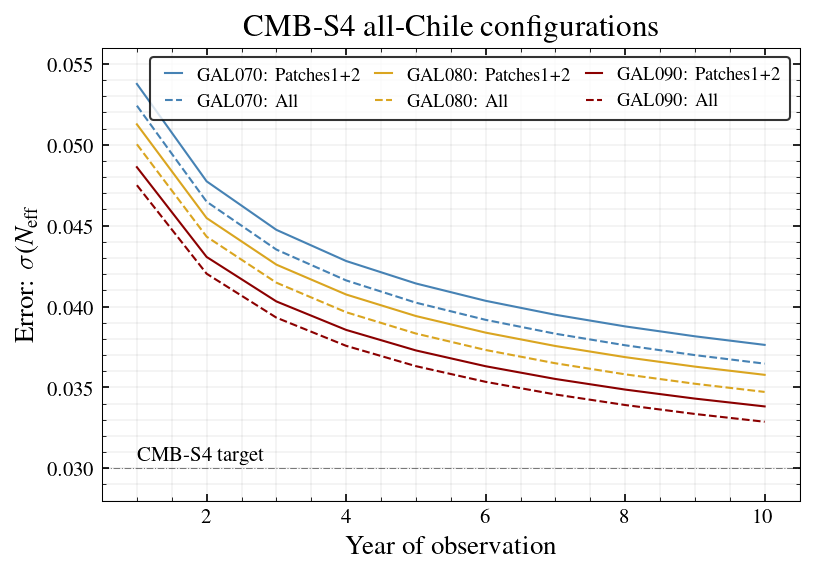

In [82]:
clf()
fsval = 13
ymin, ymax = 0.028, 0.056
xmin, xmax = 0.5, 10.5
color_dic = {'GAL070': 'steelblue', 'GAL080': 'goldenrod', 'GAL090': 'darkred'}
ls_dic = {0: '-', 1: '--'}
ax = subplot(111)
for reqd_gal_mask in sigma_neff_dic:
    
    for iter in sigma_neff_dic[reqd_gal_mask]:
        if iter == 0:
            labval = r'%s: Patches1+2' %(reqd_gal_mask)
        else:
            labval = r'%s: All' %(reqd_gal_mask)
        sigma_neff_arr = []
        for year in sigma_neff_dic[reqd_gal_mask][iter]:
            sigma_neff_arr.append( sigma_neff_dic[reqd_gal_mask][iter][year] )
        plot( year_arr, sigma_neff_arr, color = color_dic[reqd_gal_mask], ls = ls_dic[iter], label = labval)

axhline(0.03, lw = 0.5, alpha = 0.5, ls = '-.')
text(1., 0.0305, r'CMB-S4 target')
ylim( ymin, ymax )
xlim( xmin, xmax )
legend(loc = 1, fontsize = fsval-4, ncol = 3, columnspacing = 0.5, handletextpad = 0.5, handlelength = 1.5)
ylabel(r'Error: $\sigma(N_{\rm eff}$', fontsize = fsval)
xlabel(r'Year of observation', fontsize = fsval )
title(r'CMB-S4 all-Chile configurations', fontsize = fsval + 2)
grid(True, which = 'both', axis = 'both', lw = 0.2, alpha = 0.2)    
plname = 'plots/sigma_neff.png'
savefig(plname, dpi = 200.)
show()